<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные.

Значение метрики качества *F1* должно быть не меньше 0.75. 

**Цель**  

Построить модель для классификации комментариев на позитивные и негативные. 

**Структура исследования**  

1. Подготовка данных
2. Обучение моделей
3. Выводы

**Использование дополнительных модулей**  

- `pandas` – редактор баз данных  
- `numpy` – работа с многомерными массивами  
- `re` – регулярные выражения  
- `nltk` – обработка естественного языка  
- `sklearn`, `lightgbm` – машинное обучение  

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка данных из файла
df = pd.read_csv('toxic_comments.csv')
df.head

<bound method NDFrame.head of                                                      text  toxic
0       Explanation\nWhy the edits made under my usern...      0
1       D'aww! He matches this background colour I'm s...      0
2       Hey man, I'm really not trying to edit war. It...      0
3       "\nMore\nI can't make any real suggestions on ...      0
4       You, sir, are my hero. Any chance you remember...      0
...                                                   ...    ...
159566  ":::::And for the second time of asking, when ...      0
159567  You should be ashamed of yourself \n\nThat is ...      0
159568  Spitzer \n\nUmm, theres no actual article for ...      0
159569  And it looks like it was actually you who put ...      0
159570  "\nAnd ... I really don't think you understand...      0

[159571 rows x 2 columns]>

In [3]:
# Общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
# Процентное соотношение положительных или нейтральных (0) и токсичных (1) комментариев
df['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

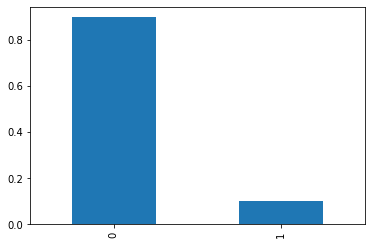

In [5]:
# Визуализация процентного соотношения комментариев
df['toxic'].value_counts(normalize=True).plot(kind='bar');

Приблизительно каждый 10-й комментарий в отзывах токсичен.

In [6]:
# Очистка исходного текста
def clear_text(text):
    '''
    В исходном тексте функция удаляет все значки кроме строчных и прописных букв,
    а также преобразует полученный текст к нижнему регистру
    '''
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = " ".join(clear_text.lower().split())
    return clear_text


df['clear_text'] = df['text'].apply(lambda x: clear_text(x))
df.head()

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [7]:
# Лексемизация очищенного текста
def token_text(text):
    '''
    Функция разбивает текст на отдельные слова (или токены)
    '''
    token_text = word_tokenize(text)
    return token_text


df['token_text'] = df['clear_text'].apply(lambda x: token_text(x))
df['token_text'].head()

0    [explanation, why, the, edits, made, under, my...
1    [d, aww, he, matches, this, background, colour...
2    [hey, man, i, m, really, not, trying, to, edit...
3    [more, i, can, t, make, any, real, suggestions...
4    [you, sir, are, my, hero, any, chance, you, re...
Name: token_text, dtype: object

In [8]:
# Лемматизация слов
def lemmatizer(tokenized_words):
    '''
    Приведение слов к нормальной (словарной) форме
    '''
    lemmatizer = WordNetLemmatizer()
    lemm_list = [lemmatizer.lemmatize(word) for word in tokenized_words]
    lemm_text = " ".join(lemm_list)
    return lemm_text


df['lemm_text'] = df['token_text'].apply(lambda x: lemmatizer(x))
df['lemm_text'].head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: lemm_text, dtype: object

In [9]:
# На примере изменения форм глагола 'match' можно наблюдать результат работы функции лемматизации
df.loc[1:1, ['clear_text', 'lemm_text']]

,clear_text,lemm_text
1,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...


## Обучение

In [10]:
# Выделение столбцов с признаками и метками
X = df['lemm_text'].astype('U')
y = df['toxic']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [11]:
# Создаем счетчик с указанием стоп-слов
stopwords = set(stopwords.words('english'))

# Создать матрицу признаков на основе меры tf-idf
tfidf = TfidfVectorizer(stop_words=stopwords)

# Создание матрицы признаков (для обучающей и тестовой выборки) на основе меры tf-idf
X_train_matrix = tfidf.fit_transform(X_train) 
X_test_matrix = tfidf.transform(X_test)

In [12]:
# Создаем функцию для оценки метрики 'F1' для моделей машинного обучения
def model_check(model):
    """
    Функция принимает на вход модель для машинного обучения
    возвращает: F1 (или F-мера)
    """
    model.fit(X_train_matrix, y_train)
    predictions = model.predict(X_test_matrix)

    f1 = f1_score(y_test, predictions)
    return round(f1, 3)

In [13]:
# Выбор моделей для обучения

# LogisticRegression
f1_lr = model_check(LogisticRegression(random_state=12345, class_weight='balanced'))

# SGDClassifier
f1_sgd = model_check(SGDClassifier(random_state=12345, class_weight='balanced'))

# LGBMClassifier
f1_lgbm = model_check(LGBMClassifier(random_state=12345, class_weight='balanced'))

# Собираем результаты в сводную таблицу
pivot_table = pd.DataFrame(data=[f1_lr, f1_sgd, f1_lgbm], columns=['F-мера'], index=['LogisticRegression',
                                                                                     'SGDClassifier',
                                                                                     'LGBMClassifier'])
pivot_table.sort_values('F-мера')

,F-мера
LGBMClassifier,0.727
SGDClassifier,0.739
LogisticRegression,0.751


In [14]:
# Подбор гиперпараметра для лучшей модели
pipe_lr = Pipeline([('vec', TfidfVectorizer(stop_words=stopwords)), ('clf', LogisticRegression(random_state=12345, class_weight='balanced'))])

C = np.linspace(7, 8, 5)

hyperparameters_lr = dict(clf__C=C)
    
gridsearch = GridSearchCV(pipe_lr, hyperparameters_lr, scoring='f1', verbose=0, n_jobs=-1)

best_model = gridsearch.fit(X_train, y_train)

predict_best = best_model.predict(X_test)

f1_best = f1_score(y_test, predict_best)

print('F-мера:', round(f1_best, 3))
print('Лучший параметр C:', best_model.best_estimator_.get_params()['clf__C'])

F-мера: 0.763
Лучший параметр C: 7.0


## Выводы

Модель логистической регрессии показала наилучший результат. Показатель контрольной метрики `f1` составляет `0.751` (гиперпараметр `class_weight='balanced`), что превосходит контрольное значение в соответствии с условиями учебного задания.  

Подбор дополнительного гиперпараметра для лучшей модели позволил повысить значение метрики качества до `0.763`.